In [1]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [2]:
# Config paths
EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: bench1_sleep_rand2_1000_200
overview file: results/bench1_sleep_rand2_1000_200/overview_res-2021-02-27_16-47-11.csv
experiment file: configs/bench1_sleep_rand2_1000_200.json


In [3]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60
5,1,10,res-2021-02-25_22-25-54,bench1_sleep_rand2_1000_200,bench1,False,60
6,1,15,res-2021-02-25_23-26-10,bench1_sleep_rand2_1000_200,bench1,False,60
7,1,20,res-2021-02-26_00-26-27,bench1_sleep_rand2_1000_200,bench1,False,60


In [4]:
res_name = overview_df[(overview_df['target'] == 1) & (overview_df['rps'] == 20)]['res_name'].iloc[0]
res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
res_logger_file

'results/bench1_sleep_rand2_1000_200/res-2021-02-26_00-26-27_logger.csv'

,ready_count,total_conc,conc_window_average,time,rps,target,lambda_over_n,current_cc
time_dt,,,,,,,,
2021-02-25 23:26:23.587309,19,23,0.660027,1.614314e+09,20,1,1.052632,1.210526
2021-02-25 23:26:25.595085,19,19,0.673320,1.614314e+09,20,1,1.052632,1.000000
2021-02-25 23:26:27.622276,19,24,0.683003,1.614314e+09,20,1,1.052632,1.263158
2021-02-25 23:26:29.626856,19,16,0.691066,1.614314e+09,20,1,1.052632,0.842105
2021-02-25 23:26:31.635410,19,20,0.699467,1.614314e+09,20,1,1.052632,1.052632


<AxesSubplot:xlabel='time_dt'>

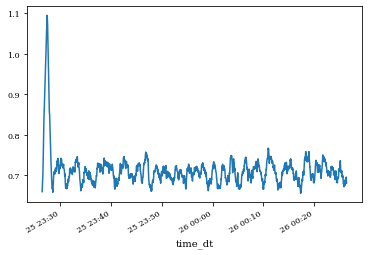

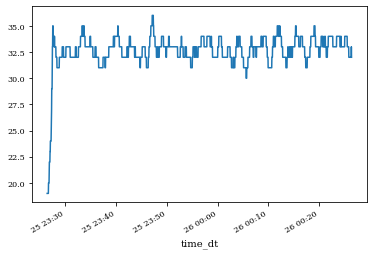

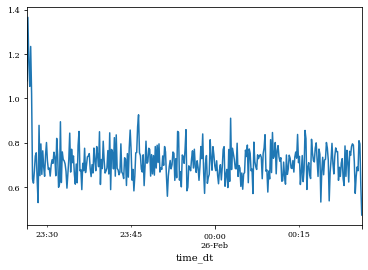

In [5]:
df = parse_util.parse_logger_file(res_logger_file)
display(df.head())

plt.figure()
df['conc_window_average'].plot()
plt.figure()
df['ready_count'].plot()
plt.figure()
df['current_cc'].resample('10s').mean().plot()

In [6]:
# plt_column = 'conc_window_average'
plt_column = 'ready_count'
# plt_column = 'current_cc'

batch_seconds_vals = np.arange(1,300,2)

def get_batch_change_results(batch_seconds_vals, plt_column, df):
    batch_change_results = []
    for batch_seconds in (batch_seconds_vals):
        start_date = df[plt_column].index.min()
        stop_date = df[plt_column].index.max()
        range_start_dates = pd.date_range(start_date, stop_date,freq=f'{batch_seconds}S')
        range_end_dates = range_start_dates.shift()[:-1]
        range_start_dates = range_start_dates[:-1]

        val_means = []
        for idx in range(len(range_start_dates)):
            vals = df.loc[(df.index < range_end_dates[idx]) & (df.index > range_start_dates[idx]), 'conc_window_average']
            val_mean = vals.mean()
            val_means.append(val_mean)

        val_means_var = np.var(val_means)
        batch_change_results.append({
            'batch_size': batch_seconds,
            'mean_var': val_means_var,
        })
    batch_res_df = pd.DataFrame(data=batch_change_results)
    return batch_res_df

batch_res_df = get_batch_change_results(batch_seconds_vals, plt_column, df)

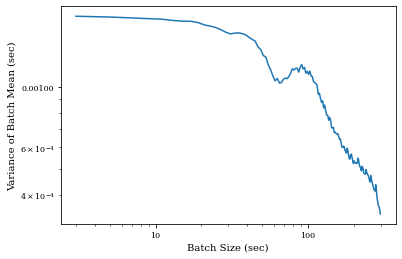

In [7]:
plt.loglog(batch_res_df['batch_size'], batch_res_df['mean_var'])
plt.xlabel('Batch Size (sec)')
plt.ylabel('Variance of Batch Mean (sec)')

parse_util.fix_log_x_plot()
parse_util.fix_log_y_plot()

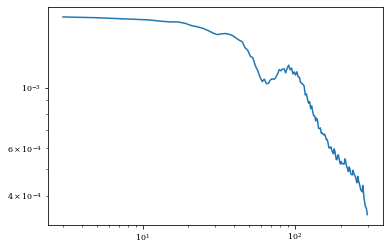

In [8]:
def get_plot_for_res_name(res_name):
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    batch_res_df = get_batch_change_results(batch_seconds_vals, plt_column, df)
    return batch_res_df['batch_size'], batch_res_df['mean_var']

xs, ys = get_plot_for_res_name(res_name)
plt.loglog(xs,ys)

In [9]:
all_res = {}
for res_name in tqdm(overview_df['res_name']):
    xs, ys = get_plot_for_res_name(res_name)
    all_res[res_name] = {
        'xs': xs,
        'ys': ys,
    }

  0%|          | 0/48 [00:00<?, ?it/s]

In [10]:
df

,ready_count,total_conc,conc_window_average,time,rps,target,lambda_over_n,current_cc
time_dt,,,,,,,,
2021-02-25 23:26:23.587309,19,23,0.660027,1.614314e+09,20,1,1.052632,1.210526
2021-02-25 23:26:25.595085,19,19,0.673320,1.614314e+09,20,1,1.052632,1.000000
2021-02-25 23:26:27.622276,19,24,0.683003,1.614314e+09,20,1,1.052632,1.263158
2021-02-25 23:26:29.626856,19,16,0.691066,1.614314e+09,20,1,1.052632,0.842105
2021-02-25 23:26:31.635410,19,20,0.699467,1.614314e+09,20,1,1.052632,1.052632
...,...,...,...,...,...,...,...,...
2021-02-26 00:26:16.881766,32,18,0.681319,1.614317e+09,20,1,0.625000,0.562500
2021-02-26 00:26:18.890587,32,24,0.687722,1.614317e+09,20,1,0.625000,0.750000
2021-02-26 00:26:20.893295,32,21,0.696116,1.614317e+09,20,1,0.625000,0.656250


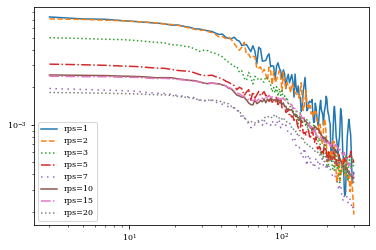

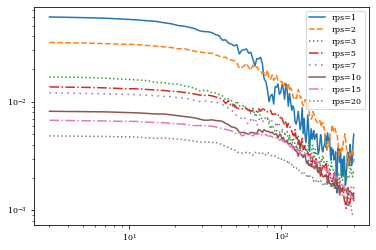

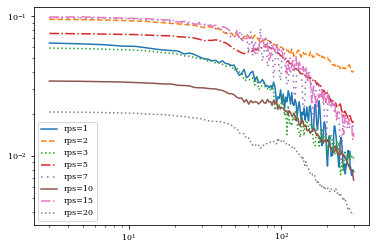

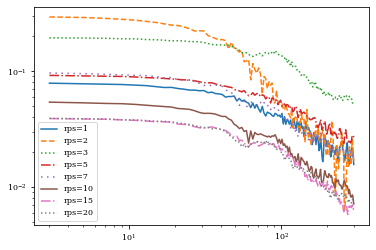

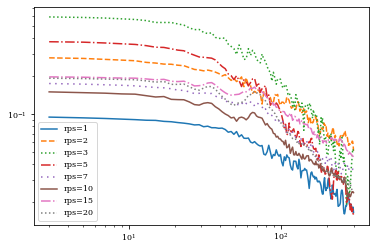

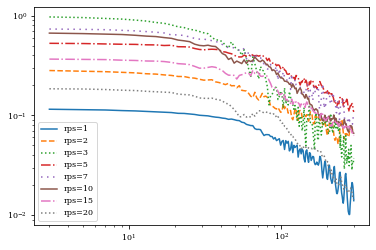

In [11]:
for target_value in overview_df['target'].unique():
    plt.figure()
    sub_df = overview_df.loc[overview_df['target'] == target_value, :]
    for rps in sub_df['rps']:
        res_name = sub_df.loc[sub_df['rps'] == rps]['res_name'].iloc[0]
        xs = all_res[res_name]['xs']
        ys = all_res[res_name]['ys']
        plt.loglog(xs, ys, label=f"rps={rps}")
    plt.legend()